Saara Mäkelä <br>
Student number 2203834 <br>
January, 26, 2025  <br>

# Exercise 1 | TKO_7092 Evaluation of Machine Learning Methods 2025

##### Prediction of the metal ion content from multi-parameter data
<b> Use K-Nearest Neighbor Regression with euclidean distance to predict total metal concentration (c_total), concentration of Cadmium (Cd) and concentration of Lead (Pb), using number of neighbors k = 1, 3, 5, 7.</b>

    - You may use Nearest Neighbor Regression from https://scikit-learn.org/stable/modules/neighbors.html   
    - Implement Leave-One-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb). 
    - Implement Leave-Replicas-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb).
    - Return your solution as a Jupyter Notebook .ipynb notebook and as a PDF-file made from it. Please, add your full name to the file name.
    - The exercise will be graded by a maximum of 2 points.
    - Submit to moodle your solution on ** Wednesday 5 of February ** at the latest.
  
<b>Please be aware that you are required to submit your individual solution.<br> 
Submissions with identical or similar code will result in a failure for the exercise.</b>

## Import libraries

In [284]:
# In this cell import all libraries you need. For example: 
import numpy as np
import pandas as pd
from scipy.stats import somersd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import LeaveOneOut, GroupKFold
import matplotlib.pyplot as plt

## Read and visualize the dataset

<p> <b>Note:</b> This dataset differs slightly from the one used in the video lectures. <br>
<b>In this dataset, some mixtures have 3 replicas, while others have 4 replicas. </b> </p> 

In the following cell: 
- Read the file water_data.csv
- Print the dimesions of the dataset (i.e. number of rows and columns) and display the first 5 rows.
- Identify the inputs and the outputs columns.
- Provide the number of mixtures with 3 replicas and 4 replicas, respectively.

In [285]:
data = pd.read_csv('water_data.csv')
print('The dimensions of the dataset:', data.shape)
display(data.head())

# let's find out the replicas
replica_counts = data.groupby(['c_total', 'Cd', 'Pb']).size()
replicas = replica_counts.value_counts()
print(replicas)

The dimensions of the dataset: (225, 6)


,c_total,Cd,Pb,Mod1,Mod2,Mod3
0,0.0,0.0,0.0,-0.999216,-0.714208,-0.414911
1,0.0,0.0,0.0,-0.990800,-0.714373,-0.238335
2,0.0,0.0,0.0,-0.990539,-0.714125,0.020788
3,14.0,0.0,14.0,-1.001247,-0.713546,0.945465
4,14.0,0.0,14.0,-1.013727,-0.714125,0.569631


3    43
4    24
Name: count, dtype: int64


<font color='violet'>The output columns are <b>c_total</b>, <b>Cd</b> and <b>Pb</b> as they are what we want to predict. The input columns are <b>Mod1</b>, <b>Mod2</b> and <b>Mod3</b> as they are used for prediction. </font>

## C-index code 

In [286]:
# In this cell is the fuction that computes the c-index value based on Somers'D statistic.
# Use this fuction as the evaluation metric in the Leave-One-Out (LOOCV) and Leave-Replicas-Out (LROCV) cross-validation methods.

def cindex(true, pred):
    s_d = somersd(true, y=pred, alternative='two-sided')
    c_index = (s_d.statistic + 1.0)/2.0
    return c_index

## Functions

<font color='violet'>Examples from [scikit-learn regressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor), [scikit-learn fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html), [medium](https://medium.com/@amirm.lavasani/classic-machine-learning-in-python-k-nearest-neighbors-knn-a06fbfaaf80a), [machine-learning-mastery](https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/), material provided in moodle and from exercises from previous courses. I also checked the answers with my friend.</font>

In [287]:
# In this cell add the functions that you need for the data analysis part.
def knn_regression(X_train, y_train, X_test, k):
    prediction = []
    knn = KNeighborsRegressor(n_neighbors=k, metric='euclidean')
    knn.fit(X_train, y_train)
    prediction = knn.predict(X_test)
    return prediction

# Leave-One-Out cross-validation
def LOOCV(X, y, k):
    loo = LeaveOneOut()
    y_true, y_pred = [], []
    for train_idx, test_idx in loo.split(X): # the train and test set split used in machine learning
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        y_pred.append(knn_regression(X_train, y_train, X_test, k)[0])
        y_true.append(y_test.values[0])
    return cindex(y_true, y_pred)

# Leave-Replicas-Out cross-validation
def LROCV(X, y, k, groups):
    groupKfold = GroupKFold(n_splits=len((np.unique(groups)))) # this was commonly used in scikit-learn
    y_true, y_pred = [], []
    for train_index, test_index in groupKfold.split(X, y, groups=groups): # the for loop is almost the same as in LOOVC but with K-fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        prediction = knn_regression(X_train, y_train, X_test, k)
        y_pred.extend(prediction.flatten())
        y_true.extend(y_test.flatten())

    return cindex(y_true, y_pred)

<font color='violet'>I decided to make an own function for the Neighbour regression. I used it in the other functions so it was easier to make a function of it. </font>

## Results for Leave-One-Out cross-validation

In [288]:
# Here run your script for Leave-One-Out cross-validation and print the corresponding results.
X = data.drop(columns=['c_total', 'Cd', 'Pb'])
y_total = data['c_total']
y_cd = data['Cd']
y_pb = data['Pb']
k_values = [1, 3, 5, 7]
total_res_cv = []
cd_res_cv = []
pb_res_cv = []
for k in k_values:
    print(f"C-index for c_total (k={k}):", LOOCV(X, y_total, k))
    total_res_cv.append(LOOCV(X, y_total, k))
    print(f"C-index for Cd (k={k}):", LOOCV(X, y_cd, k))
    cd_res_cv.append(LOOCV(X, y_cd, k))
    print(f"C-index for Pb (k={k}):", LOOCV(X, y_pb, k))
    pb_res_cv.append(LOOCV(X, y_pb, k))

C-index for c_total (k=1): 0.9082833811137173
C-index for Cd (k=1): 0.921869127656909
C-index for Pb (k=1): 0.8805487117384223
C-index for c_total (k=3): 0.9141907740422205
C-index for Cd (k=3): 0.8995907629348143
C-index for Pb (k=3): 0.8744519146448406
C-index for c_total (k=5): 0.8941012944140387
C-index for Cd (k=5): 0.8619660082682591
C-index for Pb (k=5): 0.8542614941328768
C-index for c_total (k=7): 0.8737294761532447
C-index for Cd (k=7): 0.8141520858562659
C-index for Pb (k=7): 0.8355326345680043


## Results for Leave-Replicas-Out cross-validation

In [289]:
# Here run your script for Leave-Replicas-Out cross-validation and print the corresponding results.
data_list = data.columns.tolist()
output = data_list[:3]
groups = data.groupby(output).ngroup()
total_res_r = []
cd_res_r = []
pb_res_r = []

X_v = data.drop(columns=['c_total', 'Cd', 'Pb']).values
y_total_v = data['c_total'].values
y_cd_v = data['Cd'].values
y_pb_v = data['Pb'].values
for k in k_values:
    print(f"C-index for c_total (Leave-Replicas-Out, k={k}):", LROCV(X_v, y_total_v, k, groups))
    total_res_r.append(LROCV(X_v, y_total_v, k, groups))
    print(f"C-index for Cd (Leave-Replicas-Out, k={k}):", LROCV(X_v, y_cd_v, k, groups))
    cd_res_r.append(LROCV(X_v, y_cd_v, k, groups))
    print(f"C-index for Pb (Leave-Replicas-Out, k={k}):", LROCV(X_v, y_pb_v, k, groups))
    pb_res_r.append(LROCV(X_v, y_pb_v, k, groups))

C-index for c_total (Leave-Replicas-Out, k=1): 0.8184128225175918
C-index for Cd (Leave-Replicas-Out, k=1): 0.7784273604209295
C-index for Pb (Leave-Replicas-Out, k=1): 0.7377750866496847
C-index for c_total (Leave-Replicas-Out, k=3): 0.8186734427938493
C-index for Cd (Leave-Replicas-Out, k=3): 0.7614523739925669
C-index for Pb (Leave-Replicas-Out, k=3): 0.7689480937069362
C-index for c_total (Leave-Replicas-Out, k=5): 0.8117018504039615
C-index for Cd (Leave-Replicas-Out, k=5): 0.7397168747651063
C-index for Pb (Leave-Replicas-Out, k=5): 0.7478389777425147
C-index for c_total (Leave-Replicas-Out, k=7): 0.8163712970202415
C-index for Cd (Leave-Replicas-Out, k=7): 0.7153088069486784
C-index for Pb (Leave-Replicas-Out, k=7): 0.7618490833924918


## Plot Leave-One-Out and Leave-Replicas-Out Results

Note: You may plot the results as they were presented in the video lecture (refer to MOOC2-Module 2 .pptx slides).

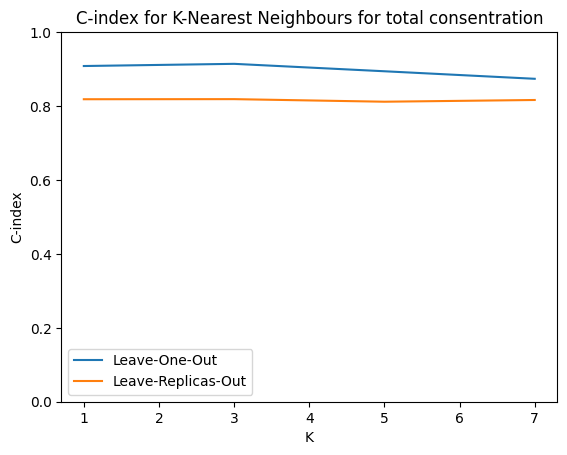

In [290]:
plt.figure()
plt.plot(k_values, total_res_cv, label='Leave-One-Out')
plt.plot(k_values, total_res_r, label='Leave-Replicas-Out')
plt.title('C-index for K-Nearest Neighbours for total consentration')
plt.xlabel('K')
plt.ylabel('C-index')
plt.ylim(ymin=0, ymax=1)
plt.legend()

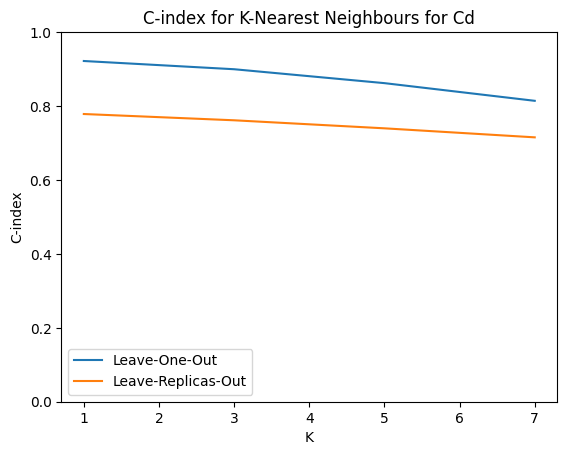

In [291]:
plt.figure()
plt.plot(k_values, cd_res_cv, label='Leave-One-Out')
plt.plot(k_values, cd_res_r, label='Leave-Replicas-Out')
plt.title('C-index for K-Nearest Neighbours for Cd')
plt.xlabel('K')
plt.ylabel('C-index')
plt.ylim(ymin=0, ymax=1)
plt.legend()

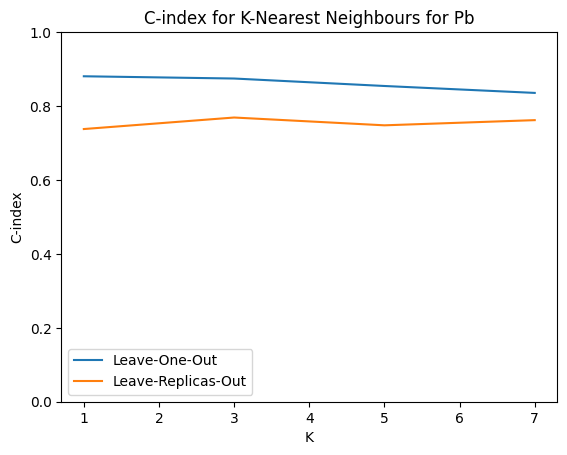

In [292]:
plt.figure()
plt.plot(k_values, pb_res_cv, label='Leave-One-Out')
plt.plot(k_values, pb_res_r, label='Leave-Replicas-Out')
plt.title('C-index for K-Nearest Neighbours for Pb')
plt.xlabel('K')
plt.ylabel('C-index')
plt.ylim(ymin=0, ymax=1)
plt.legend()

## Interpretation of results
#### Answer the following questions based on the results obtained
1. Which cross-validation approach produced more optimistic results, and why?
2. Which cross-validation method provides a better estimate of the model's performance on unseen mixtures? Explain your answer.

#### Answers:
<font color='violet'>1. The leave-one-out cross-validation produced more optimistic results. It produced better results because it leaves only one case out at a time which gives it a more data to train on. The leave-replicas-out leaves more cases out at a time so it doesn't have as much data for it to train on. </font>

<font color='violet'> 2. Leave-replicas-out provides a better estimate for unseen mixtures. The leave-replicas-out leaves the groups out and tests only the unique datapoints. It doesn't predict the "big picture" instead it focuses on the single datapoint and therefore gives better estimates. The leave-one-out loops the data multiple times and can make predictions of the whole data. The leave-replicas-out makes more realistic predictions and therefore better. </font>